# Steerable 3D Spherical Neurons

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
SEED = 239

import os 

import numpy as np
np.random.seed(SEED)
np.set_printoptions(precision=4)

import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
import matplotlib.transforms as mtransforms

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial.transform import Rotation as R
from scipy.special import softmax

from sklearn.metrics import confusion_matrix

from tqdm import tqdm

from models import PointCMLP, SteerableModel

from utils import (plot_confusion_matrix,
                   get_tetris_data, plot_shapes, 
                   visualize_skeleton, get_edges,
                   score, build_mlgp, 
                   construct_filter_banks, unembed_points, 
                   transform_parameters, build_steerable_model,
                   random_axis_angle, torch_rotation_matrix, entropy)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__, device

('1.8.1+cu102', device(type='cuda'))

## Creating a steerable spherical classifer
in the following steps:

**Step 1**. Train the ancestor MLGP.

**Step 2**. Transform the hidden unit parameters into filter banks.

**Step 3**. Fix the learned parameters and add the interpolation coefficients $v^k$ as new parameters to fulfill the steerability constraint $\rightarrow$ Steerable spherical classifier.

### Step 1

#### Load the UTKinect skeleton data

In [4]:
data_path = 'utkinect_skeletons_data/'

action_to_label = {
    'sitDown': 0,
    'throw': 1,
    'carry': 2,
    'push': 3,
    'waveHands': 4,
    'walk': 5,
    'clapHands': 6,
    'pull': 7,
    'pickUp': 8,
    'standUp': 9
}

Xtrain =  np.load(os.path.join(data_path, 'Xtrain.npy'))
Ytrain =  np.load(os.path.join(data_path, 'Ytrain.npy'))
Xval =  np.load(os.path.join(data_path, 'Xval.npy'))
Yval =  np.load(os.path.join(data_path, 'Yval.npy'))
Xtest  =  np.load(os.path.join(data_path, 'Xtest.npy'))
Ytest  =  np.load(os.path.join(data_path, 'Ytest.npy'))

In [5]:
# shuffle the data:
idcs = np.arange(len(Xtrain))
np.random.shuffle(idcs)
Xtrain = Xtrain[idcs]
Ytrain = Ytrain[idcs]

Text(0.5, 0.92, 'skeleton for action "walk" (5)')

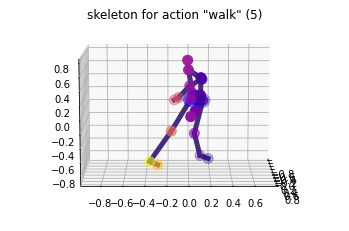

In [6]:
# sanity check:
idx = np.random.choice(len(Xtrain))
skeleton = Xtrain[idx]
edges = get_edges(skeleton)
visualize_skeleton(skeleton.T, edges, size=100, show_grid=True, azim=0)
plt.title(f'skeleton for action "{list(action_to_label.keys())[np.argmax(list(action_to_label.values()) == Ytrain[idx])]}" ({Ytrain[idx]})')

In [7]:
Xtrain = torch.from_numpy(Xtrain).float().to(device)
Ytrain = torch.from_numpy(Ytrain).to(device)

Xval = torch.from_numpy(Xval).float().to(device)
Yval = torch.from_numpy(Yval).to(device)

Xtest = torch.from_numpy(Xtest).float().to(device)
Ytest = torch.from_numpy(Ytest).to(device)

print('Xtrain.shape, Ytrain.shape:', Xtrain.shape, Ytrain.shape)
print('Xval.shape, Yval.shape:',     Xval.shape, Yval.shape)
print('Xtest.shape, Ytest.shape:',   Xtest.shape, Ytest.shape)

Xtrain.shape, Ytrain.shape: torch.Size([2295, 20, 3]) torch.Size([2295])
Xval.shape, Yval.shape: torch.Size([670, 20, 3]) torch.Size([670])
Xtest.shape, Ytest.shape: torch.Size([3062, 20, 3]) torch.Size([3062])


#### Train the MLGP on the shapes in the canonical orientation

In [8]:
N_GEOMETRIC_NEURONS = 12
OUTPUT_DIM = 10 # len(set(Ytrain.numpy()))

In [9]:
# set the seed here:
torch.manual_seed(SEED)

# instantiate the model:
model = build_mlgp(input_shape=Xtrain.shape[1:], output_dim=OUTPUT_DIM, hidden_layer_sizes=[N_GEOMETRIC_NEURONS], bias=False)

print(model)
print('total number of trainable parameters:', sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())]))
print()

model = model.float().to(device)

# define the loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10000

# train the model:
for i in range(epochs): 
        y_pred = model(Xtrain)
        loss = criterion(y_pred, Ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = score(y_pred.detach(), Ytrain)

        if i % 500 == 0:
            y_val_pred = model(Xval)
            val_loss = criterion(y_val_pred, Yval)
            val_acc = score(y_val_pred.detach(), Yval)
            
            print('epoch: %d, loss: %.3f,  acc:  %.3f, val_loss: %.3f,  val_acc:  %.3f' % (i, loss.item(), acc, val_loss.item(), val_acc))

print('epoch: %d, loss: %.3f,  acc:  %.3f, val_loss: %.3f,  val_acc:  %.3f' % (i, loss.item(), acc, val_loss.item(), val_acc))


model: MLGP
PointCMLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=100, out_features=12, bias=False)
  )
  (out_layer): Linear(in_features=14, out_features=10, bias=False)
)
total number of trainable parameters: 1340

epoch: 0, loss: 2.313,  acc:  0.156, val_loss: 2.302,  val_acc:  0.152
epoch: 500, loss: 0.839,  acc:  0.712, val_loss: 0.865,  val_acc:  0.696
epoch: 1000, loss: 0.580,  acc:  0.782, val_loss: 0.623,  val_acc:  0.754
epoch: 1500, loss: 0.460,  acc:  0.831, val_loss: 0.519,  val_acc:  0.810
epoch: 2000, loss: 0.382,  acc:  0.866, val_loss: 0.448,  val_acc:  0.848
epoch: 2500, loss: 0.319,  acc:  0.892, val_loss: 0.389,  val_acc:  0.867
epoch: 3000, loss: 0.266,  acc:  0.913, val_loss: 0.340,  val_acc:  0.881
epoch: 3500, loss: 0.222,  acc:  0.928, val_loss: 0.306,  val_acc:  0.897
epoch: 4000, loss: 0.186,  acc:  0.941, val_loss: 0.282,  val_acc:  0.904
epoch: 4500, loss: 0.157,  acc:  0.952, val_loss: 0.265,  val_acc:  0.904
epoch: 5000, loss: 0.133,  acc

#### Test the model on the test shape data

In [10]:
y_test_pred = model(Xtest)

test_acc = score(y_test_pred.detach(), Ytest)
print('test_acc:  %.5f' % test_acc)

test_acc:  0.92880


Confusion matrix, without normalization


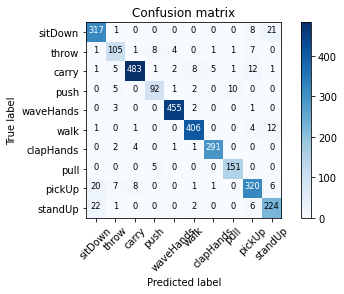

In [11]:
targets = Ytest.cpu().numpy()
predictions = torch.argmax(y_test_pred.detach(), axis=1).cpu().numpy()
cm = confusion_matrix(targets, predictions)
plot_confusion_matrix(cm, classes=list(action_to_label.keys()))#, normalize=True)

### Step 2

The main function in this step is `construct_filter_banks`:
- takes in *non-normalized* (raw) spheres $\tilde{S}_k \in \mathbb{R}^5$, i.e., parameters, extracted from the trained ancestor MLGP model;
- computes the initial rotations $R_O^k$, i.e., from the original sphere centers $c_k$ to (1, 1, 1);
- computes the tetrahedron rotations $R_{Ti}$, i.e., rotations transforming (1, 1, 1) into the other three vertices;
- constructs the filter banks for each sphere as discussed in Section 4 in the paper

\begin{equation*}
	B(\tilde{S}_k) = 
	\begin{bmatrix}
		R_O^{k\top} R_{T0} R_O^{k} \tilde{S}_k \\
		R_O^{k\top} R_{T1} R_O^{k} \tilde{S}_k \\
		R_O^{k\top} R_{T2} R_O^{k} \tilde{S}_k \\ 
		R_O^{k\top} R_{T3} R_O^{k} \tilde{S}_k \\
	\end{bmatrix} ~;
\end{equation*}

- returns an array of $R_O^k$ (optionally) and an array of the constructed $B(\tilde{S}_k)$.

To demonstrate how it works, we first extract the ancestor model hidden layer (i.e., geometric neurons) spheres, and then take one of them to form a filter bank:

In [12]:
# extract the spheres from the ancestor model:
original_state_dict = model.state_dict()

# get the geometric neuron spheres:
hidden_name = 'hidden_layers.0.weight' 
hidden_spheres = original_state_dict[hidden_name]            # (n_geometric_neurons x N_points*5)

# each sphere is a parameter vector of length 5;
# each geometric neuron contains a number of spheres corresponding to the number of input points
# in the point set

# reshape to (n_geometric_neurons x N_points x 5):
hidden_spheres_numpy = hidden_spheres.detach().cpu().numpy().reshape(len(hidden_spheres), -1, 5)
print('hidden_spheres_numpy.shape:', hidden_spheres_numpy.shape) 


# e.g., select the third sphere from the second geometric neuron:
one_sphere = hidden_spheres_numpy[1,2,:]
print('\nS_tilde_k = ', one_sphere)

# construct a filter bank for this sphere:
init_rotation, filter_bank = construct_filter_banks(one_sphere, return_init_rotations=True)
print('\nR_O^k =\n', init_rotation, '\n\nB(S_tilde_k) =\n', filter_bank)

hidden_spheres_numpy.shape: (12, 20, 5)

S_tilde_k =  [-2.5476  0.6094  0.0804 -0.1381 -0.3713]

R_O^k =
 [[[ 0.4189 -0.6476 -0.6365]
  [ 0.7434  0.6471 -0.1692]
  [ 0.5214 -0.4023  0.7525]]] 

B(S_tilde_k) =
 [[-2.5476  0.6094  0.0804 -0.1381 -0.3713]
 [ 1.2799  1.3504  1.8456 -0.1381 -0.3713]
 [ 0.298  -2.5677  0.4316 -0.1381 -0.3713]
 [ 0.9696  0.6079 -2.3576 -0.1381 -0.3713]]


#### Visualize

We normalize, i.e., *unembed*, the resulting spheres to get their Euclidean $\mathbb{R}^3$ representation.

By unembedding the 5-vectors, we will get the first three elements that represent the Euclidean coordinates of the sphere center:


the four sphere centers:
 [[ 6.8618 -1.6415 -0.2167]
 [-3.4475 -3.6371 -4.9711]
 [-0.8027  6.9159 -1.1624]
 [-2.6116 -1.6373  6.3501]]


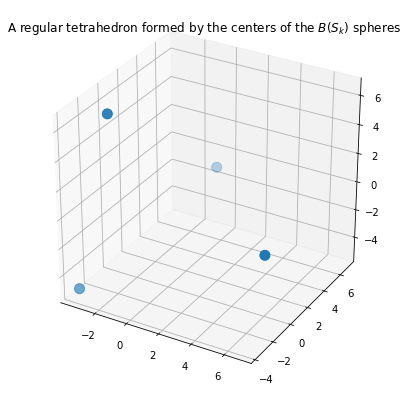

In [13]:
# the centers of the filter bank spheres:
centers = unembed_points(filter_bank)

print('\nthe four sphere centers:\n', centers)
fig = plt.figure(1, figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')         
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=100)
plt.title('A regular tetrahedron formed by the centers of the $B(S_k)$ spheres')
plt.show()

**Step 2** is wrapped into the function `transform_parameters`: 
- takes in the trained ancestor MLGP model;

- transforms its parameters --- uses the hidden layer spheres to create the filter banks and keeps the output (classification) layer the same;

- returns the initial rotations $R_O^k$, the filter banks $B(\tilde{S}_k)$, and the ancestor model output layer parameters.

In [14]:
transformed_parameters = transform_parameters(model) # used in the experiments further down

### Step 3


**Step 3** is wrapped into the `build_steerable_model` function: 
- creates a steerable model with interpolation coefficients $v^k$ according to the constraint (13) in the paper;

   - since $v^k$ depends on the rotation $R_B$ applied to the input (see (12) in the paper), we will make the rotation parameters, i.e., three axis-angle parameters, the only free parameters of the model (as discussed in Section 5.2 in the paper);

- the rest of the model parameters are set to be the ones obtained in Step 2 (the filter banks and the unchanged output layer) and are fixed.

In [15]:
# choose initial model parameters:
init_axis_angle = random_axis_angle()

# use the initial parameters and the transformed ancestor model parameters obtained in Step 2
# to build a steerable spherical classifier:
steerable_model = build_steerable_model(input_shape=Xtrain.shape[1:], 
                                        output_dim=OUTPUT_DIM,
                                        hidden_layer_sizes=[N_GEOMETRIC_NEURONS],
                                        init_axis_angle=init_axis_angle,
                                        transformed_parameters=transformed_parameters,
                                        print_hidden_layer_output=False).to(device)
print(steerable_model)
print('total number of trainable parameters:', \
      sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, steerable_model.parameters())]))

print('\ninit_axis_angle:\n', init_axis_angle)
print('\nsteerable_model.axis_angle:\n', steerable_model.axis_angle)

SteerableModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=400, out_features=12, bias=False)
  )
  (out_layer): Linear(in_features=14, out_features=10, bias=False)
)
total number of trainable parameters: 3

init_axis_angle:
 [ 0.2288  0.0725 -0.2987]

steerable_model.axis_angle:
 Parameter containing:
tensor([ 0.2288,  0.0725, -0.2987], device='cuda:0', dtype=torch.float64,
       requires_grad=True)


## Paper experiments

#### Get the ancestor MLGP activations
(used in the experiments further down)

In [16]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.hidden_layers[0].register_forward_hook(get_activation('hidden_layer'))
output = model(Xtest)

# the ground truth hidden activations -- the ancestor MLGP hidden layer output:
gt_hidden_activations = activation['hidden_layer'].detach().cpu().numpy()

# gt_hidden_activations

### The known rotation experiment (Section 5.3)

In [17]:
np.random.seed(SEED)
torch.manual_seed(SEED)

n_trials = 1000

# the parameter of additive uniform noise to apply to the rotated shapes:
distortions = [0.0, 0.005, 0.01, 0.02, 0.03, 0.05]


init_axis_angles = []
accs = dict()          # classification accuracies for the perturbed rotated shapes
dists = dict()         # L1 distances to the ground truth hidden activations

# the same for the ancestor:
ancestor_accs = dict() 
ancestor_dists = dict()


for distortion in distortions:
    accs[distortion] = []  
    dists[distortion] = [] 
    ancestor_accs[distortion] = [] 
    ancestor_dists[distortion] = [] 
    
    print('\ndistortion:', distortion)
    
    for n in range(n_trials):       
        # construct a random ground truth rotation:
        init_axis_angle = random_axis_angle()
        init_axis_angles.append(init_axis_angle)
        gt_rotation = torch_rotation_matrix(init_axis_angle).float().to(device)

        # rotate the shapes with the ground truth:
        test_data = Xtest.reshape(-1, 3) @ gt_rotation.T
        test_data = test_data.reshape(Xtest.shape)
        test_label = Ytest

        # add uniform noise to the transformed shapes:
        noise = distortion * (2 * torch.rand(test_data.shape).to(device) - 1)
        test_data += noise
        
        ancestor_data = Xtest + noise

        # construct the steerable model with the initial axis-angle parameters:
        steerable_model = build_steerable_model(input_shape=test_data.shape[1:], 
                                                output_dim=OUTPUT_DIM,
                                                hidden_layer_sizes=[N_GEOMETRIC_NEURONS],
                                                init_axis_angle=init_axis_angle,
                                                transformed_parameters=transformed_parameters,
                                                print_hidden_layer_output=False).float().to(device)

        # get the model output:
        output = steerable_model(test_data)
        ancestor_output = model(ancestor_data)
        
        # compute the model accuracy for the perturbed rotated shapes:
        acc = score(output.detach(), test_label)
        accs[distortion].append(acc)
        
        ancestor_acc = score(ancestor_output.detach(), test_label)
        ancestor_accs[distortion].append(ancestor_acc)
        
        # compute the L1 distance between the hidden activations:
        hidden_activations = steerable_model.hidden_layer_activations.cpu().numpy()
        dist = np.linalg.norm(hidden_activations - gt_hidden_activations, ord=1, axis=1)
        dist = np.mean(dist)
        dists[distortion].append(dist)
        
        ancestor_hidden_activations = model.hidden_layer_activations.cpu().numpy()
        ancestor_dist = np.linalg.norm(ancestor_hidden_activations - gt_hidden_activations, ord=1, axis=1)
        ancestor_dist = np.mean(ancestor_dist)
        ancestor_dists[distortion].append(ancestor_dist)

        # if n % 10 == 0:
            # print('\nexperiment #%d/%d' % (n+1, n_trials))
            # print('\nadditive_uniform_noise:\n', noise)
            # print('\ngt_rotation:\n', gt_rotation)
            # print('\nacc:  %.3f' % acc)
            
    print()
    print('ancestor acc:      %.3f +/- %.3f' % (np.mean(ancestor_accs[distortion]), np.std(ancestor_accs[distortion])))
    print('steerable acc:     %.3f +/- %.3f' % (np.mean(accs[distortion]), np.std(accs[distortion])))
    print()
    print('ancestor L1 dist:  %.3f +/- %.3f' % (np.mean(ancestor_dists[distortion]), np.std(ancestor_dists[distortion])))
    print('steerable L1 dist: %.3f +/- %.3f' % (np.mean(dists[distortion]), np.std(dists[distortion])))
    print(end='\n\n')


distortion: 0.0

ancestor acc:      0.929 +/- 0.000
steerable acc:     0.929 +/- 0.000

ancestor L1 dist:  0.000 +/- 0.000
steerable L1 dist: 0.000 +/- 0.000



distortion: 0.005

ancestor acc:      0.924 +/- 0.002
steerable acc:     0.924 +/- 0.002

ancestor L1 dist:  0.530 +/- 0.002
steerable L1 dist: 0.530 +/- 0.002



distortion: 0.01

ancestor acc:      0.911 +/- 0.003
steerable acc:     0.911 +/- 0.003

ancestor L1 dist:  1.059 +/- 0.005
steerable L1 dist: 1.059 +/- 0.005



distortion: 0.02

ancestor acc:      0.871 +/- 0.005
steerable acc:     0.871 +/- 0.005

ancestor L1 dist:  2.119 +/- 0.009
steerable L1 dist: 2.119 +/- 0.009



distortion: 0.03

ancestor acc:      0.822 +/- 0.006
steerable acc:     0.823 +/- 0.006

ancestor L1 dist:  3.179 +/- 0.014
steerable L1 dist: 3.179 +/- 0.014



distortion: 0.05

ancestor acc:      0.719 +/- 0.007
steerable acc:     0.720 +/- 0.007

ancestor L1 dist:  5.304 +/- 0.022
steerable L1 dist: 5.304 +/- 0.022


